In [1]:
import sys
print(sys.prefix)
# !git clone https://github.com/zhouhaoyi/Informer2020.git
# !git clone https://github.com/zhouhaoyi/ETDataset.git
!ls

/home/ailabguest/anaconda3/envs/babble
create-csv.ipynb	informer_checkpoints   output-with-date-average.csv
create-sin-table.ipynb	informer.ipynb	       output-with-date.csv
ETDataset		informer-sin.ipynb     results
Informer2020		output.csv	       sin-with-date.csv
informer2.ipynb		output-with-date2.csv  time-epoc.py


In [2]:
import sys
if not 'Informer2020' in sys.path:
    sys.path += ['Informer2020']

In [4]:

%pip install -r ./Informer2020/requirements.txt

     |████████████████████████████████| 13.1 MB 10.6 MB/s eta 0:00:01
     |████████████████████████████████| 14.5 MB 12.4 MB/s eta 0:00:01
     |████████████████████████████████| 10.5 MB 2.4 MB/s eta 0:00:01
     |████████████████████████████████| 6.7 MB 12.3 MB/s eta 0:00:01
     |████████████████████████████████| 735.5 MB 5.4 kB/s  eta 0:00:01     |█████▉                          | 135.3 MB 12.1 MB/s eta 0:00:50     |███████████▊                    | 270.5 MB 10.7 MB/s eta 0:00:44     |██████████████████████████▏     | 600.9 MB 12.1 MB/s eta 0:00:12
  Attempting uninstall: numpy
    Found existing installation: numpy 1.17.5
    Uninstalling numpy-1.17.5:
      Successfully uninstalled numpy-1.17.5
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.1.3
    Uninstalling matplotlib-3.1.3:
      Successfully uninstalled matplotlib-3.1.3
  Attempting uninstall: pandas
    Found existing installation: pandas 1.0.0
    Uninstalling pandas-1.0.0:
      Successf

In [3]:

from utils.tools import dotdict
from exp.exp_informer import Exp_Informer
import torch


In [4]:
args = dotdict()

args.model = 'informer' # model of experiment, options: [informer, informerstack, informerlight(TBD)]

args.data = 'custom' # data
args.root_path = './' # root path of data file
args.data_path = 'sin-with-date.csv' # data file
args.features = 'S' # forecasting task, options:[M, S, MS]; M:multivariate predict multivariate, S:univariate predict univariate, MS:multivariate predict univariate
args.target = 'pressure' # target feature in S or MS task
args.freq = 's' # freq for time features encoding, options:[s:secondly, t:minutely, h:hourly, d:daily, b:business days, w:weekly, m:monthly], you can also use more detailed freq like 15min or 3h
args.checkpoints = './informer_checkpoints' # location of model checkpoints

args.seq_len = 48#mod 96 # input sequence length of Informer encoder
args.label_len = 24#mod 48 # start token length of Informer decoder
args.pred_len = 12#mod 24 # prediction sequence length
# Informer decoder input: concat[start token series(label_len), zero padding series(pred_len)]

args.enc_in = 1 # encoder input size
args.dec_in = 1 # decoder input size
args.c_out = 1 # output size
args.factor = 5 # probsparse attn factor
args.d_model = 256#modified # dimension of model
args.n_heads = 1#modified 8 # num of heads
args.e_layers = 1#modified 2 # num of encoder layers
args.d_layers = 1 # num of decoder layers
args.d_ff = 1024#modified 2048 # dimension of fcn in model
args.dropout = 0.05 # dropout
args.attn = 'prob' # attention used in encoder, options:[prob, full]
args.embed = 'timeF' # time features encoding, options:[timeF, fixed, learned]
args.activation = 'gelu' # activation
args.distil = True # whether to use distilling in encoder
args.output_attention = False # whether to output attention in ecoder
args.mix = True
args.padding = 0

args.batch_size = 16 #modified 32
args.learning_rate = 0.0001
args.loss = 'mse'
args.lradj = 'type1'
args.use_amp = False # whether to use automatic mixed precision training

args.num_workers = 0
args.itr = 1
args.train_epochs = 3#modified
args.patience = 1#modified
args.des = 'exp'

args.use_gpu = True if torch.cuda.is_available() else False
args.gpu = 0

args.use_multi_gpu = False
args.devices = '0,1,2,3'


In [5]:
import torch.cuda

print(torch.cuda.is_available())

False


In [6]:
args.use_gpu = True if torch.cuda.is_available() and args.use_gpu else False

if args.use_gpu and args.use_multi_gpu:
    args.devices = args.devices.replace(' ','')
    device_ids = args.devices.split(',')
    args.device_ids = [int(id_) for id_ in device_ids]
    args.gpu = args.device_ids[0]

In [7]:
# Set augments by using data name
data_parser = {
    'ETTh1':{'data':'ETTh1.csv','T':'OT','M':[7,7,7],'S':[1,1,1],'MS':[7,7,1]},
    'ETTh2':{'data':'ETTh2.csv','T':'OT','M':[7,7,7],'S':[1,1,1],'MS':[7,7,1]},
    'ETTm1':{'data':'ETTm1.csv','T':'OT','M':[7,7,7],'S':[1,1,1],'MS':[7,7,1]},
    'ETTm2':{'data':'ETTm2.csv','T':'OT','M':[7,7,7],'S':[1,1,1],'MS':[7,7,1]},
}
if args.data in data_parser.keys():
    data_info = data_parser[args.data]
    args.data_path = data_info['data']
    args.target = data_info['T']
    args.enc_in, args.dec_in, args.c_out = data_info[args.features]

In [12]:
args.detail_freq = args.freq
args.freq = args.freq[-1:]


In [17]:

print("hei " + args.freq[-1:])
print( args.freq)

hei s
s


In [18]:
print('Args in experiment:')
print(args)
print(f"Max epochs: {args.train_epochs}")


Args in experiment:
{'model': 'informer', 'data': 'custom', 'root_path': './', 'data_path': 'sin-with-date.csv', 'features': 'S', 'target': 'pressure', 'freq': 's', 'checkpoints': './informer_checkpoints', 'seq_len': 48, 'label_len': 24, 'pred_len': 12, 'enc_in': 1, 'dec_in': 1, 'c_out': 1, 'factor': 5, 'd_model': 256, 'n_heads': 1, 'e_layers': 1, 'd_layers': 1, 'd_ff': 1024, 'dropout': 0.05, 'attn': 'prob', 'embed': 'timeF', 'activation': 'gelu', 'distil': True, 'output_attention': False, 'mix': True, 'padding': 0, 'batch_size': 16, 'learning_rate': 0.0001, 'loss': 'mse', 'lradj': 'type1', 'use_amp': False, 'num_workers': 0, 'itr': 1, 'train_epochs': 3, 'patience': 1, 'des': 'exp', 'use_gpu': False, 'gpu': 0, 'use_multi_gpu': False, 'devices': '0,1,2,3', 'detail_freq': 's'}
Max epochs: 3


In [19]:
Exp = Exp_Informer

In [20]:
for ii in range(args.itr):
    # setting record of experiments
    setting = '{}_{}_ft{}_sl{}_ll{}_pl{}_dm{}_nh{}_el{}_dl{}_df{}_at{}_fc{}_eb{}_dt{}_mx{}_{}_{}'.format(args.model, args.data, args.features, 
                args.seq_len, args.label_len, args.pred_len,
                args.d_model, args.n_heads, args.e_layers, args.d_layers, args.d_ff, args.attn, args.factor, args.embed, args.distil, args.mix, args.des, ii)

    # set experiments
    exp = Exp(args)
    
    # train
    print('>>>>>>>start training : {}>>>>>>>>>>>>>>>>>>>>>>>>>>'.format(setting))
    exp.train(setting)
    
    # test
    print('>>>>>>>testing : {}<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<'.format(setting))
    exp.test(setting)

    torch.cuda.empty_cache()
    

Use CPU
>>>>>>>start training : informer_custom_ftS_sl48_ll24_pl12_dm256_nh1_el1_dl1_df1024_atprob_fc5_ebtimeF_dtTrue_mxTrue_exp_0>>>>>>>>>>>>>>>>>>>>>>>>>>
train 4141
val 589
test 1189
	iters: 100, epoch: 1 | loss: 0.1722058
	speed: 0.1153s/iter; left time: 77.8267s
	iters: 200, epoch: 1 | loss: 0.0439605
	speed: 0.1141s/iter; left time: 65.6313s
Epoch: 1 cost time: 29.687222480773926
Epoch: 1, Steps: 258 | Train Loss: 0.1403827 Vali Loss: 0.0179155 Test Loss: 0.0183820
Validation loss decreased (inf --> 0.017916).  Saving model ...
Updating learning rate to 0.0001
	iters: 100, epoch: 2 | loss: 0.0195071
	speed: 0.2122s/iter; left time: 88.5081s
	iters: 200, epoch: 2 | loss: 0.0123702
	speed: 0.1096s/iter; left time: 34.7505s
Epoch: 2 cost time: 28.18103575706482
Epoch: 2, Steps: 258 | Train Loss: 0.0185400 Vali Loss: 0.0112475 Test Loss: 0.0113699
Validation loss decreased (0.017916 --> 0.011247).  Saving model ...
Updating learning rate to 5e-05
	iters: 100, epoch: 3 | loss: 0.01012

In [21]:
import os

# set saved model path
setting = 'informer_custom_ftS_sl48_ll24_pl12_dm256_nh1_el1_dl1_df1024_atprob_fc5_ebtimeF_dtTrue_mxTrue_exp_0'
# path = os.path.join(args.checkpoints,setting,'checkpoint.pth')


In [22]:
exp = Exp(args)

exp.predict(setting, True)


Use CPU
pred 1


In [23]:
import numpy as np

prediction = np.load('./results/'+setting+'/real_prediction.npy')

prediction.shape


(1, 12, 1)

In [24]:
# here is the detailed code of function predict

def predict(exp, setting, load=False):
    pred_data, pred_loader = exp._get_data(flag='pred')
        
    if load:
        path = os.path.join(exp.args.checkpoints, setting)
        best_model_path = path+'/'+'checkpoint.pth'
        exp.model.load_state_dict(torch.load(best_model_path))

    exp.model.eval()
        
    preds = []
        
    for i, (batch_x,batch_y,batch_x_mark,batch_y_mark) in enumerate(pred_loader):
        batch_x = batch_x.float().to(exp.device)
        batch_y = batch_y.float()
        batch_x_mark = batch_x_mark.float().to(exp.device)
        batch_y_mark = batch_y_mark.float().to(exp.device)

        # decoder input
        if exp.args.padding==0:
            dec_inp = torch.zeros([batch_y.shape[0], exp.args.pred_len, batch_y.shape[-1]]).float()
        elif exp.args.padding==1:
            dec_inp = torch.ones([batch_y.shape[0], exp.args.pred_len, batch_y.shape[-1]]).float()
        else:
            dec_inp = torch.zeros([batch_y.shape[0], exp.args.pred_len, batch_y.shape[-1]]).float()
        dec_inp = torch.cat([batch_y[:,:exp.args.label_len,:], dec_inp], dim=1).float().to(exp.device)
        # encoder - decoder
        if exp.args.use_amp:
            with torch.cuda.amp.autocast():
                if exp.args.output_attention:
                    outputs = exp.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)[0]
                else:
                    outputs = exp.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
        else:
            if exp.args.output_attention:
                outputs = exp.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)[0]
            else:
                outputs = exp.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
        f_dim = -1 if exp.args.features=='MS' else 0
        batch_y = batch_y[:,-exp.args.pred_len:,f_dim:].to(exp.device)
        
        pred = outputs.detach().cpu().numpy()#.squeeze()
        
        preds.append(pred)

    preds = np.array(preds)
    preds = preds.reshape(-1, preds.shape[-2], preds.shape[-1])
    
    # result save
    folder_path = './results/' + setting +'/'
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    
    np.save(folder_path+'real_prediction.npy', preds)
    
    return preds



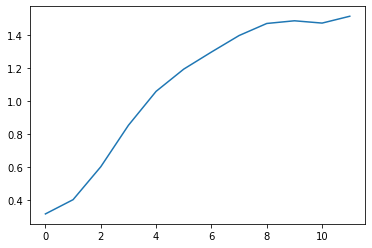

In [25]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(prediction[0,:,-1])
plt.show()


In [26]:
from data.data_loader import Dataset_Pred
from torch.utils.data import DataLoader


In [27]:
Data = Dataset_Pred
timeenc = 0 if args.embed!='timeF' else 1
flag = 'pred'; shuffle_flag = False; drop_last = False; batch_size = 1

freq = args.detail_freq

data_set = Data(
    root_path=args.root_path,
    data_path=args.data_path,
    flag=flag,
    size=[args.seq_len, args.label_len, args.pred_len],
    features=args.features,
    target=args.target,
    timeenc=timeenc,
    freq=freq
)
data_loader = DataLoader(
    data_set,
    batch_size=batch_size,
    shuffle=shuffle_flag,
    num_workers=args.num_workers,
    drop_last=drop_last)



In [28]:
len(data_set), len(data_loader)

(1, 1)

In [29]:

preds = np.load('./results/'+setting+'/pred.npy')
trues = np.load('./results/'+setting+'/true.npy')

# [samples, pred_len, dimensions]
preds.shape, trues.shape




((1184, 12, 1), (1184, 12, 1))

In [32]:
import matplotlib.pyplot as plt

%pip install seaborn
import seaborn as sns

     |████████████████████████████████| 292 kB 5.5 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


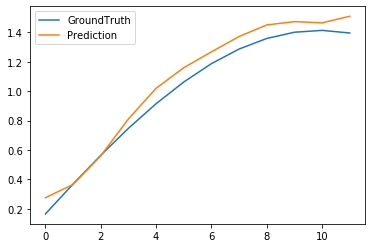

In [76]:
plt.figure()
plt.plot(trues[0,:,-1], label='GroundTruth')
plt.plot(preds[0,:,-1], label='Prediction')
plt.legend()
plt.show()

In [61]:
print (preds[0,:,-1])
print (len(preds))
print (preds.flatten())


[0.27609667 0.3659031  0.5608478  0.81143147 1.0204396  1.1601977
 1.2681509  1.3725703  1.4511265  1.4739215  1.4656022  1.510391  ]
1184
[ 2.76096672e-01  3.65903109e-01  5.60847819e-01  8.11431468e-01
  1.02043962e+00  1.16019773e+00  1.26815093e+00  1.37257028e+00
  1.45112646e+00  1.47392154e+00  1.46560216e+00  1.51039100e+00
  4.86721963e-01  5.61693847e-01  7.58791924e-01  9.86712635e-01
  1.16038203e+00  1.26964188e+00  1.35170758e+00  1.42715681e+00
  1.47369623e+00  1.47011387e+00  1.44728971e+00  1.47378850e+00
  6.81584179e-01  7.67681599e-01  9.53480184e-01  1.14895201e+00
  1.28469348e+00  1.36331391e+00  1.41968799e+00  1.46752524e+00
  1.48423195e+00  1.45544934e+00  1.41868329e+00  1.40471375e+00
  8.42470884e-01  9.52164114e-01  1.12210131e+00  1.27879763e+00
  1.37275124e+00  1.41888952e+00  1.44802141e+00  1.46652997e+00
  1.45166957e+00  1.39584470e+00  1.34376192e+00  1.27042484e+00
  1.00599408e+00  1.13228166e+00  1.28052735e+00  1.39733481e+00
  1.45102513e+00